<a href="https://colab.research.google.com/github/Irvingrh8/Regresssion_HousePricing_Forecast/blob/main/Regression_HousePricing_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cargar bibiliotecas y funciones

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics

Para este notebook, explorare una base de datos con el precio de venta y caracteristicas de casas, asi mismo desarrollo un modelo de regresión lineal, regresión robusta (Huber) y regresión poliniomial, y con ello analizar cual algoritmo es mas eficiente para este caso particular .

En las siguientes lineas de codigo cargo funciones que seran utilizadas en distintas partes de este notebook

In [ ]:
def correlacion(dataframe, grafica=True, matrix=False, tamaño =(12,8)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()                   
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm", 
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(), 
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [ ]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

In [ ]:
def regressionEvaluationMetrics(predictions,y_test,title):
    
    plt.figure(figsize=(8,6))
    plt.scatter(predictions,y_test,cmap='plasma',alpha=0.5)
    plt.xlabel('Prediction')
    plt.ylabel('Real value')
    plt.title(title)
    diagonal = np.linspace(0, np.max(y_test), 100)
    plt.plot(diagonal, diagonal, '-r')
    plt.show()
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(np.log1p(y_test), np.log1p(predictions))))

# Lectura datos y selección de características

__Cargar etiquetas__

In [ ]:
# Carge el archivo de CVS en mi perfil de Github, y de ahi tomo los datos.
hp = pd.read_csv('https://raw.githubusercontent.com/Irvingrh8/Regresssion_HousePricing_Forecast/main/Datos/house_price.csv')
print(hp.shape)
hp.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [ ]:
hp.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


Despues de revisar el tipo de dato de las features encontradas en el dataset, procedo a hacer una revisión mas profunda con la siguiente formula.

In [ ]:
describe_datos(hp)

dtypes  null  nunique  \
Id               int64     0     1460   
MSSubClass       int64     0       15   
MSZoning        object     0        5   
LotFrontage    float64   259      110   
LotArea          int64     0     1073   
Street          object     0        2   
Alley           object  1369        2   
LotShape        object     0        4   
LandContour     object     0        4   
Utilities       object     0        2   
LotConfig       object     0        5   
LandSlope       object     0        3   
Neighborhood    object     0       25   
Condition1      object     0        9   
Condition2      object     0        8   
BldgType        object     0        5   
HouseStyle      object     0        8   
OverallQual      int64     0       10   
OverallCond      int64     0        9   
YearBuilt        int64     0      112   
YearRemodAdd     int64     0       61   
RoofStyle       object     0        6   
RoofMatl        object     0        8   
Exterior1st     object     0       15   
Exterior2nd     object     0       16   
MasVnrType      object     8        4   
MasVnrArea     float64     8      327   
ExterQual       object     0        4   
ExterCond       object     0        5   
Foundation      object     0        6   
BsmtQual        object    37        4   
BsmtCond        object    37        4   
BsmtExposure    object    38        4   
BsmtFinType1    object    37        6   
BsmtFinSF1       int64     0      637   
BsmtFinType2    object    38        6   
BsmtFinSF2       int64     0      144   
BsmtUnfSF        int64     0      780   
TotalBsmtSF      int64     0      721   
Heating         object     0        6   
HeatingQC       object     0        5   
CentralAir      object     0        2   
Electrical      object     1        5   
1stFlrSF         int64     0      753   
2ndFlrSF         int64     0      417   
LowQualFinSF     int64     0       24   
GrLivArea        int64     0      861   
BsmtFullBath     int64     0        4   
BsmtHalfBath     int64     0        3   
FullBath         int64     0        4   
HalfBath         int64     0        3   
BedroomAbvGr     int64     0        8   
KitchenAbvGr     int64     0        4   
KitchenQual     object     0        4   
TotRmsAbvGrd     int64     0       12   
Functional      object     0        7   
Fireplaces       int64     0        4   
FireplaceQu     object   690        5   
GarageType      object    81        6   
GarageYrBlt    float64    81       97   
GarageFinish    object    81        3   
GarageCars       int64     0        5   
GarageArea       int64     0      441   
GarageQual      object    81        5   
GarageCond      object    81        5   
PavedDrive      object     0        3   
WoodDeckSF       int64     0      274   
OpenPorchSF      int64     0      202   
EnclosedPorch    int64     0      120   
3SsnPorch        int64     0       20   
ScreenPorch      int64     0       76   
PoolArea         int64     0        8   
PoolQC          object  1453        3   
Fence           object  1179        4   
MiscFeature     object  1406        4   
MiscVal          int64     0       21   
MoSold           int64     0       12   
YrSold           int64     0        5   
SaleType        object     0        9   
SaleCondition   object     0        6   
SalePrice        int64     0      663   

                                                          unique  
Id             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
MSSubClass     [60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...  
MSZoning                               [RL, RM, C (all), FV, RH]  
LotFrontage    [65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan...  
LotArea        [8450, 9600, 11250, 9550, 14260, 14115, 10084,...  
Street                                              [Pave, Grvl]  
Alley                                          [nan, Grvl, Pave]  
LotShape                                    [Reg, IR1, IR2, IR3]  
LandContour                                 [Lvl, 

Al parecer se cuentan tanto con variables categoricas como con variables numericas o continuas. Asi mismo, hay valores nulos dentro de la base de datos. Estos aspectos del dataset seran tratados, proseguire a analizar estadistica descriptiva de las features.

In [ ]:
hp.describe()

(                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
 count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
 mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
 std     421.610009    42.300571    24.284752    9981.264932     1.382997   
 min       1.000000    20.000000    21.000000    1300.000000     1.000000   
 25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
 50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
 75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
 max    1460.000000   190.000000   313.000000  215245.000000    10.000000   
 
        OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
 count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
 mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
 std       1.112799    30.202904     20.645407   181.066207   456.098091   
 

# Analisis Exploratorio de datos y manejo de Features

<Axes: >

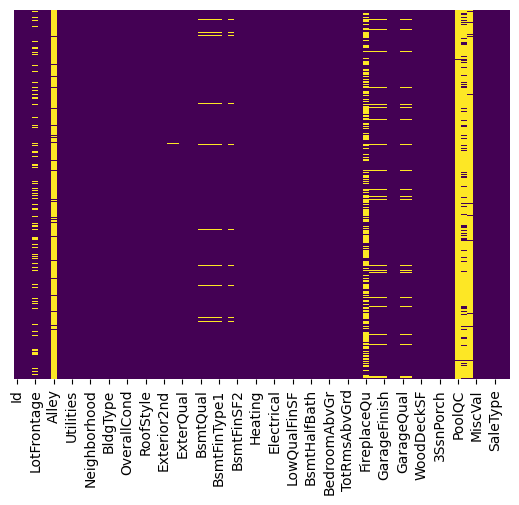

In [ ]:
sns.heatmap(hp.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Los valores nulos resaltados en el grafico anterior seran tratados en el siguiente subtitulo

<Figure size 50000x10000 with 0 Axes>

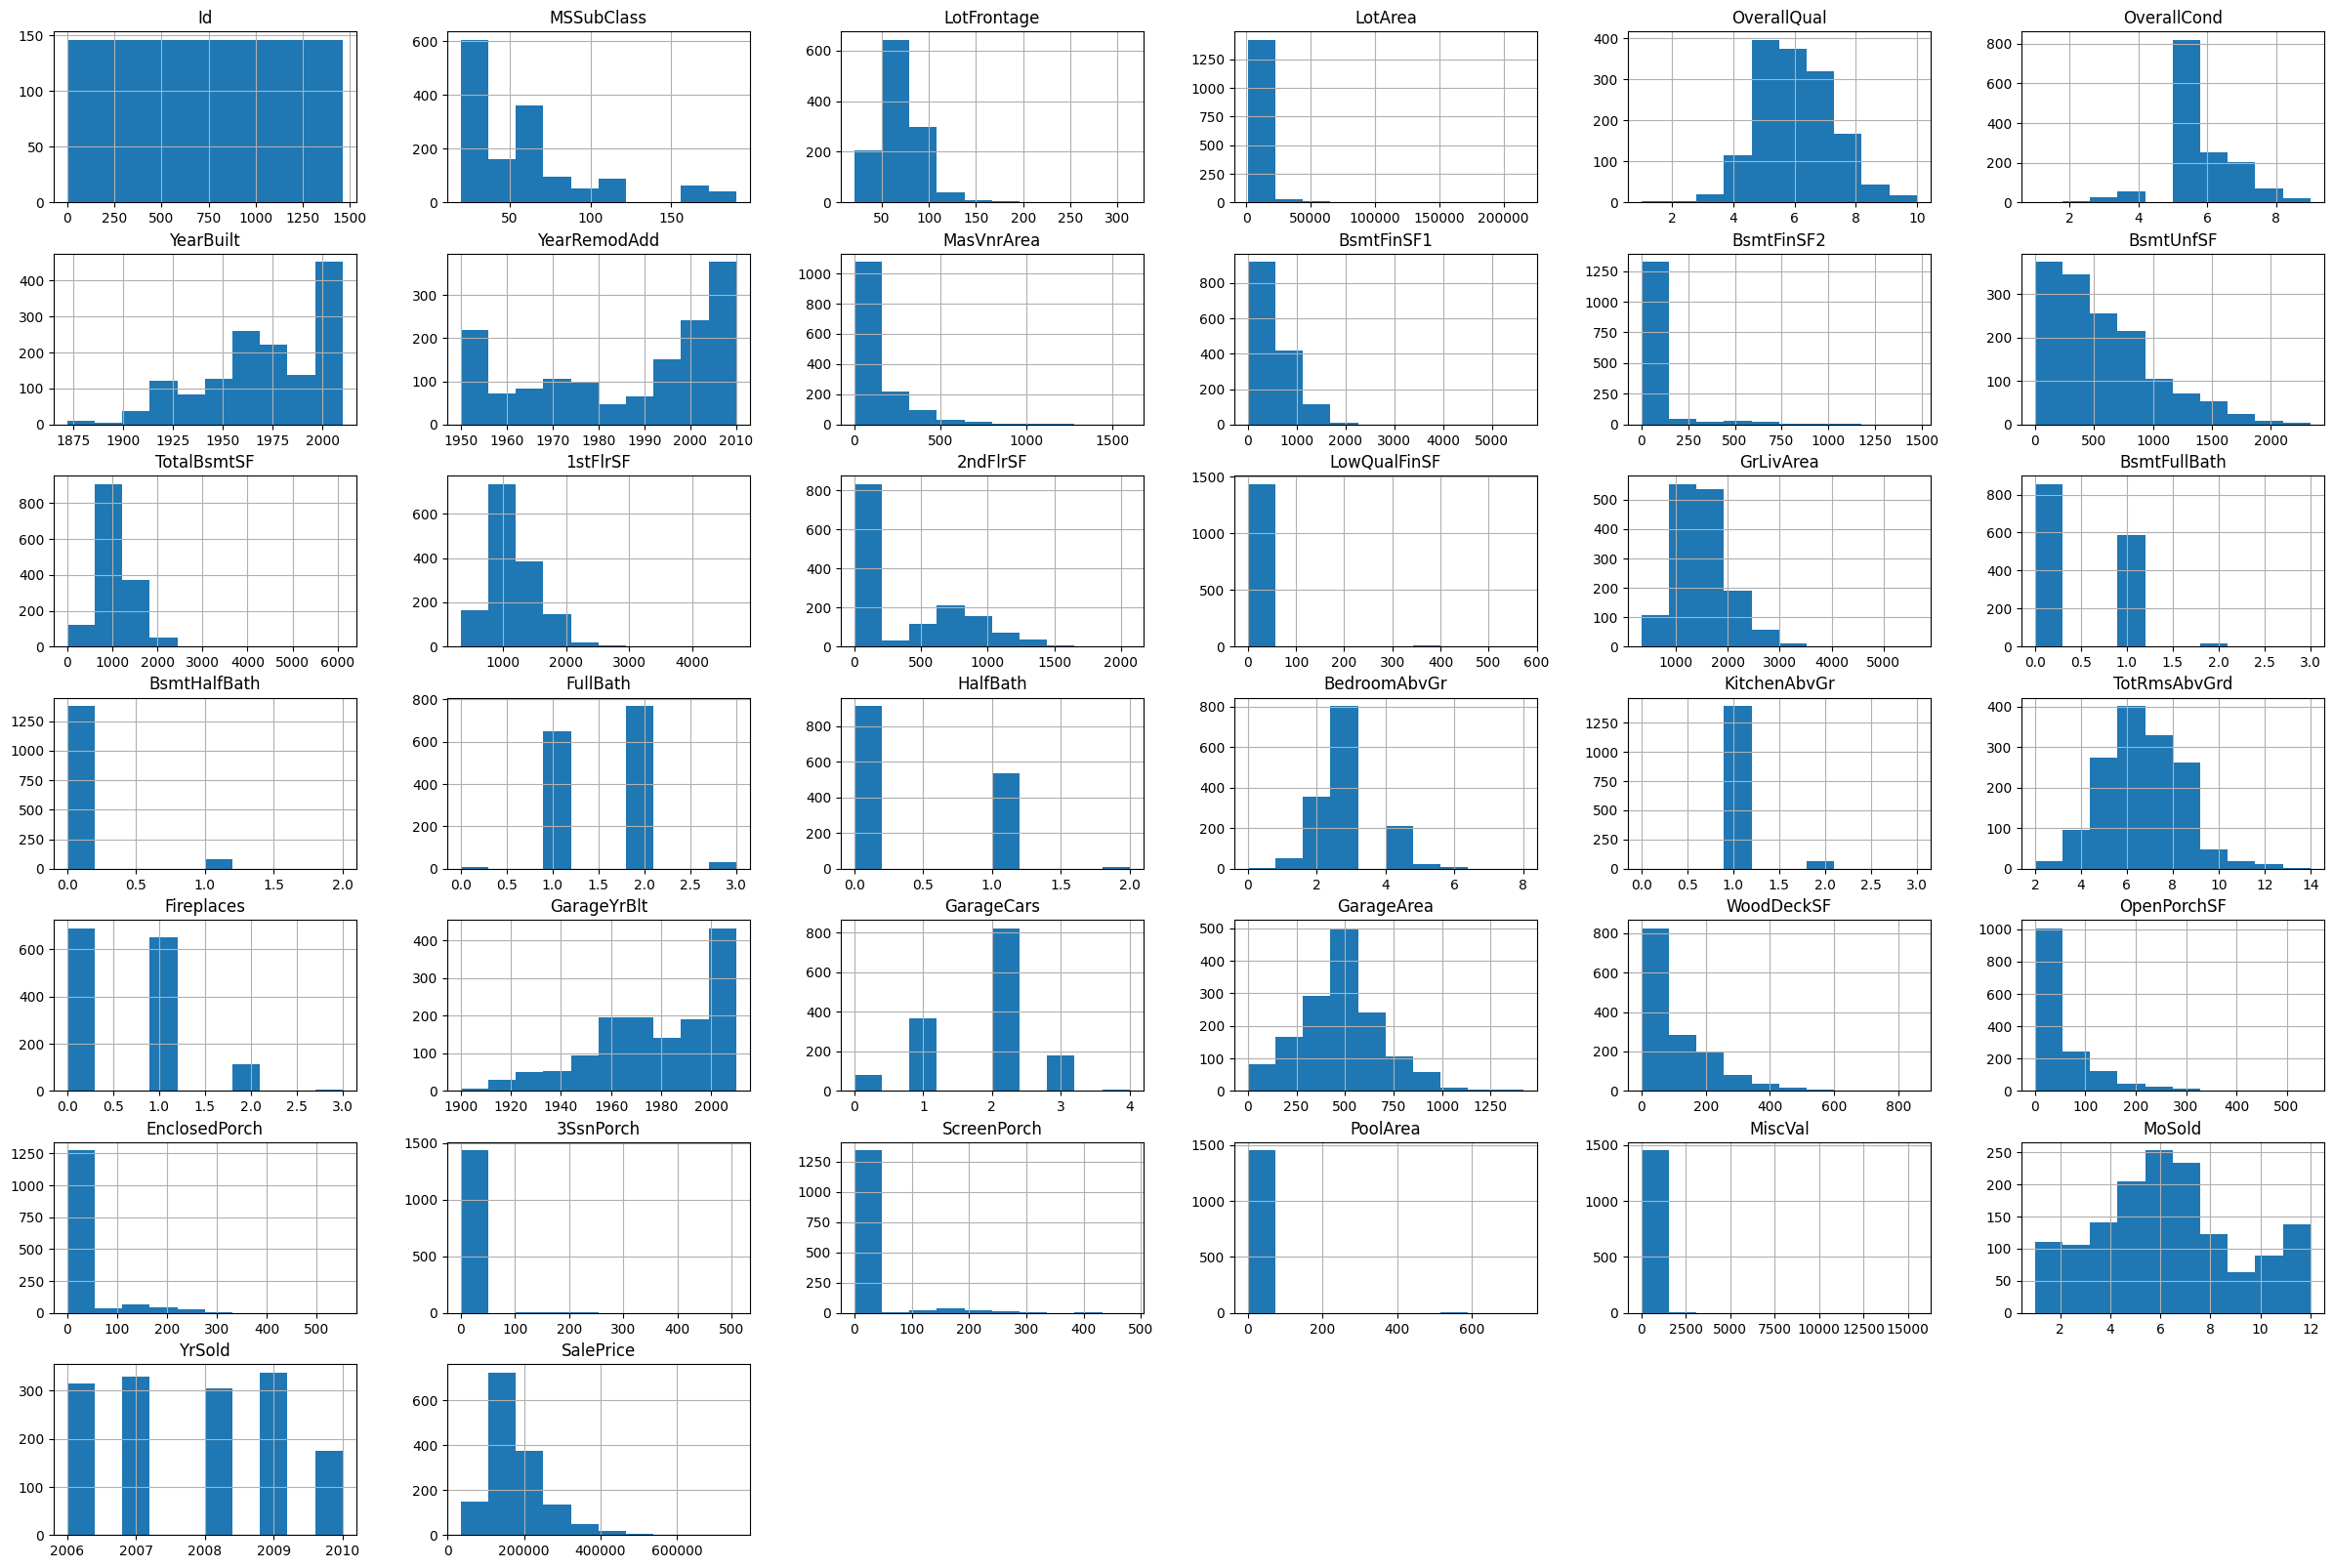

In [ ]:
fig=plt.figure(figsize=(500,100))
hp.hist( figsize=[30,20])
plt.show()

Podemos ver en el histograma de las variables, que algunas cuentan con una distribucion normal, pero no la mayoria.

## Manejo de Valores Nulos

In [ ]:
# Identificamos las variables con valores nulos
hp.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
MasVnrType          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

In [ ]:
# Primero quiero saber cuantas caracteristicas cuentan con menos de 10% de valores nulos
b=[]
for column in hp.columns:
    a = hp[column].isnull().sum()
    if(a/len(hp) <= 0.10):
        b.append(column)
print(len(b))

75


In [ ]:
# Ahora identifico las caracteristicas con mas de 10% de valores nulos
c=[]
for column in hp.columns:
    a = hp[column].isnull().sum()
    if(a/len(hp) >= 0.10):
        c.append(column)
print(c)

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [ ]:
# Elimine las columnas con mas de 10% de valores nulos, asi como la columna ID ya que no aporta valor de dominio a la regresion
hp = hp.drop(columns=['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Id'],axis=1)

In [ ]:
# Revisamos nuevamente los valores nulos que tenemos en el dataset
hp.isnull().sum().sort_values(ascending=False)

GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
BsmtFinType2     38
BsmtExposure     38
BsmtQual         37
BsmtCond         37
BsmtFinType1     37
MasVnrArea        8
MasVnrType        8
Electrical        1
KitchenAbvGr      0
BedroomAbvGr      0
HalfBath          0
FullBath          0
BsmtHalfBath      0
BsmtFullBath      0
KitchenQual       0
GrLivArea         0
TotRmsAbvGrd      0
Functional        0
MSSubClass        0
Fireplaces        0
ScreenPorch       0
SaleCondition     0
SaleType          0
YrSold            0
MoSold            0
MiscVal           0
PoolArea          0
3SsnPorch         0
2ndFlrSF          0
EnclosedPorch     0
OpenPorchSF       0
WoodDeckSF        0
PavedDrive        0
GarageArea        0
GarageCars        0
LowQualFinSF      0
HeatingQC         0
1stFlrSF          0
CentralAir        0
LotArea           0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0


Proseguire a identificar las variables categoricas y numericas, para con base a esto determinar el tipo de tratamiento sobre los valores nulos que persisen en la base de datos

In [ ]:
# Identificamos columnas con variables numericas
num_col = [column for column in hp.columns if hp[column].dtype != 'O']
print(num_col)
print(len(num_col))

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
36


In [ ]:
# Identificamos columnas con variables categoricas
cate_col = [column for column in hp.columns if hp[column].dtype == 'O']
print(cate_col)
print(len(cate_col))

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
38


Procedere a rellenar los valores nulos de las variables categoricas y numericas

In [ ]:
# Variables numericas con valores nulos
num_col_na = [column for column in hp.columns if (hp[column].isnull().sum()>0) and (hp[column].dtype != 'O')]
print(num_col_na)
print(len(num_col_na))

['MasVnrArea', 'GarageYrBlt']
2


In [ ]:
# Variables categoricas con valores nulos
cate_col_na = [column for column in hp.columns if (hp[column].isnull().sum()>0) and (hp[column].dtype == 'O')]
print(cate_col_na)
print(len(cate_col_na))

['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
11


In [ ]:
# En valores nulos de variables categoricas reemplazamos con la palabra "missing"
import statistics as stats
for column in cate_col_na:
    hp[column] = hp[column].fillna('Missing')

In [ ]:
# En valores nulos de variables numericas reemplazamos con la media de la variable
for column in num_col_na:
    hp[column] = hp[column].fillna(hp[column].mean())

In [ ]:
# Revisamos nuevamente los valores nulos que tenemos en el dataset, y 
# vemos que ya no hay presentes
hp.shape, hp.isnull().sum().sort_values(ascending=False)

((1460, 74),
 MSSubClass       0
 GarageYrBlt      0
 Fireplaces       0
 Functional       0
 TotRmsAbvGrd     0
 KitchenQual      0
 KitchenAbvGr     0
 BedroomAbvGr     0
 HalfBath         0
 FullBath         0
 BsmtHalfBath     0
 BsmtFullBath     0
 GrLivArea        0
 LowQualFinSF     0
 2ndFlrSF         0
 1stFlrSF         0
 Electrical       0
 GarageType       0
 GarageFinish     0
 MSZoning         0
 GarageCars       0
 SaleCondition    0
 SaleType         0
 YrSold           0
 MoSold           0
 MiscVal          0
 PoolArea         0
 ScreenPorch      0
 3SsnPorch        0
 EnclosedPorch    0
 OpenPorchSF      0
 WoodDeckSF       0
 PavedDrive       0
 GarageCond       0
 GarageQual       0
 GarageArea       0
 CentralAir       0
 HeatingQC        0
 Heating          0
 TotalBsmtSF      0
 YearBuilt        0
 OverallCond      0
 OverallQual      0
 HouseStyle       0
 BldgType         0
 Condition2       0
 Condition1       0
 Neighborhood     0
 LandSlope        0
 LotCon

In [ ]:
# Doy un vistazo rapido de como se ven las variables despues del manejo
# de valores nulos
hp.head(25)

NameError: ignored

In [ ]:
# Resto los valores del año vendido para obtener el total de años en las diferentes
# variables correspondientes a años.
for feature in ['YearBuilt','YearRemodAdd','GarageYrBlt']:  
    hp[feature]=hp['YrSold']-hp[feature]

## Estandarización y Normalización de features

Aplicare dos procesos de estandarizacion de los datos, uno para normalizar tanto las columnas como las filas

In [ ]:
# Funcion normalize
def do_normalize(X):
    #normalized_X = preprocessing.normalize(X)
    X_normalized = Normalizer().fit_transform(X)
    return X_normalized

In [ ]:
# Funcion standardscaler
def do_standardscaling(X):
    X_scaled = StandardScaler().fit_transform(X)
    #X_scaled = preprocessing.scale(X)
    return X_scaled

In [ ]:
# normalized aplicado a variables numericas
housing_data_normalize = do_normalize(hp[num_col])

# standardscaler aplicado a variables numericas
housing_data_standardscale = do_standardscaling(hp[num_col])

## One hot encoding variables categoricas

Ahora, realizare One hot enconding, lo cual consiste en crear una columna binaria (que solo puede contener los valores 0 o 1) para cada valor único que exista en las variables categóricas de nuestro dataset.

In [ ]:
hp[cate_col].nunique()

MSZoning          5
Street            2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        5
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          5
BsmtCond          5
BsmtExposure      5
BsmtFinType1      7
BsmtFinType2      7
Heating           6
HeatingQC         5
CentralAir        2
Electrical        6
KitchenQual       4
Functional        7
GarageType        7
GarageFinish      4
GarageQual        6
GarageCond        6
PavedDrive        3
SaleType          9
SaleCondition     6
dtype: int64

In [ ]:
describe_datos(hp[cate_col])

dtypes  null  nunique  \
MSZoning       object     0        5   
Street         object     0        2   
LotShape       object     0        4   
LandContour    object     0        4   
Utilities      object     0        2   
LotConfig      object     0        5   
LandSlope      object     0        3   
Neighborhood   object     0       25   
Condition1     object     0        9   
Condition2     object     0        8   
BldgType       object     0        5   
HouseStyle     object     0        8   
RoofStyle      object     0        6   
RoofMatl       object     0        8   
Exterior1st    object     0       15   
Exterior2nd    object     0       16   
MasVnrType     object     0        5   
ExterQual      object     0        4   
ExterCond      object     0        5   
Foundation     object     0        6   
BsmtQual       object     0        5   
BsmtCond       object     0        5   
BsmtExposure   object     0        5   
BsmtFinType1   object     0        7   
BsmtFinType2   object     0        7   
Heating        object     0        6   
HeatingQC      object     0        5   
CentralAir     object     0        2   
Electrical     object     0        6   
KitchenQual    object     0        4   
Functional     object     0        7   
GarageType     object     0        7   
GarageFinish   object     0        4   
GarageQual     object     0        6   
GarageCond     object     0        6   
PavedDrive     object     0        3   
SaleType       object     0        9   
SaleCondition  object     0        6   

                                                          unique  
MSZoning                               [RL, RM, C (all), FV, RH]  
Street                                              [Pave, Grvl]  
LotShape                                    [Reg, IR1, IR2, IR3]  
LandContour                                 [Lvl, Bnk, Low, HLS]  
Utilities                                       [AllPub, NoSeWa]  
LotConfig                    [Inside, FR2, Corner, CulDSac, FR3]  
LandSlope                                        [Gtl, Mod, Sev]  
Neighborhood   [CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...  
Condition1     [Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...  
Condition2     [Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...  
BldgType                   [1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]  
HouseStyle     [2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...  
RoofStyle             [Gable, Hip, Gambrel, Mansard, Flat, Shed]  
RoofMatl       [CompShg, WdShngl, Metal, WdShake, Membran, Ta...  
Exterior1st    [VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, ...  
Exterior2nd    [VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, ...  
MasVnrType               [BrkFace, None, Stone, BrkCmn, Missing]  
ExterQual                                       [Gd, TA, Ex, Fa]  
ExterCond                                   [TA, Gd, Fa, Po, Ex]  
Foundation            [PConc, CBlock, BrkTil, Wood, Slab, Stone]  
BsmtQual                               [Gd, TA, Ex, Missing, Fa]  
BsmtCond                               [TA, Gd, Missing, Fa, Po]  
BsmtExposure                           [No, Gd, Mn, Av, Missing]  
BsmtFinType1             [GLQ, ALQ, Unf, Rec, BLQ, Missing, LwQ]  
BsmtFinType2             [Unf, BLQ, Missing, ALQ, Rec, LwQ, GLQ]  
Heating                    [GasA, GasW, Grav, Wall, OthW, Floor]  
HeatingQC                                   [Ex, Gd, TA, Fa, Po]  
CentralAir                                                [Y, N]  
Electrical            [SBrkr, FuseF, FuseA, FuseP, Mix, Missing]  
KitchenQual                                     [Gd, TA, Ex, Fa]  
Functional               [Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]  
GarageType     [Attchd, Detchd, BuiltIn, CarPort, Missing, Ba...  
GarageFinish                            [RFn, Unf, Fin, Missing]  
GarageQual                         [TA, Fa, Gd, Missing, Ex, Po]  
GarageCond                         [TA, Fa, Missing, Gd, Po, Ex]  
PavedDrive                                

In [ ]:
#Aplicamos One hot enconding
he = pd.get_dummies(hp[cate_col],
                   drop_first=True) 
print(he.shape)
he.head()

(1460, 207)


MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  Street_Pave  \
0            0            0            1            0            1   
1            0            0            1            0            1   
2            0            0            1            0            1   
3            0            0            1            0            1   
4            0            0            1            0            1   

   LotShape_IR2  LotShape_IR3  LotShape_Reg  LandContour_HLS  LandContour_Low  \
0             0             0             1                0                0   
1             0             0             1                0                0   
2             0             0             0                0                0   
3             0             0             0                0                0   
4             0             0             0                0                0   

   LandContour_Lvl  Utilities_NoSeWa  LotConfig_CulDSac  LotConfig_FR2  \
0                1                 0                  0              0   
1                1                 0                  0              1   
2                1                 0                  0              0   
3                1                 0                  0              0   
4                1                 0                  0              1   

   LotConfig_FR3  LotConfig_Inside  LandSlope_Mod  LandSlope_Sev  \
0              0                 1              0              0   
1              0                 0              0              0   
2              0                 1              0              0   
3              0                 0              0              0   
4              0                 0              0              0   

   Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     0   

   Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  \
0                     0                     1                     0   
1                     0                     0                     0   
2                     0                     1                     0   
3                     0                     0                     1   
4                     0                     0                     0   

   Neighborhood_Edwards  Neighborhood_Gilbert  Neighborhood_IDOTRR  \
0                     0                     0                    0   
1                     0                     0                    0   
2                     0                     0                    0   
3                     0                     0                    0   
4                     0                     0                    0   

   Neighborhood_MeadowV  Neighborhood_Mitchel  Neighborhood_NAmes  \
0                     0                     0                   0   
1                     0                     0                   0   
2                     0                     0                   0   
3                     0                     0                   0   
4                     0                     0                   0   

   Neighborhood_NPkVill  Neighborhood_NWAmes  Neighborhood_NoRidge  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     1   

   Neighborhood_NridgHt  Neighborhood_OldTown  Neighborhood_SWISU  \
0                     0                     0                   0  

In [ ]:
hp=hp.drop(columns=cate_col)
df=pd.concat([hp, he], axis=1)
df.shape

(1460, 243)

In [ ]:
#Llevar la etiqueta hasta la ultima posición 
df = df[[c for c in df if c != 'SalePrice'] + ['SalePrice']]
print(df.shape)
df.info()

(1460, 243)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 243 entries, MSSubClass to SalePrice
dtypes: float64(2), int64(34), uint8(207)
memory usage: 705.9 KB


In [ ]:
# Terminamos con 243 columans de momento
len(df.columns)

243

# Seleccion de Feautres

En esta sección, procedere a utilizar metodologías aplicadas para una selección mas apripiada de features, eliminando variables no relevantes y redundantes.

## Eliminar variables no relevantes 

Análisis de correlación con la variable respuesta

In [ ]:
corr_y = df.corr()['SalePrice'].abs()


In [ ]:
corr_y.sort_values(ascending = False).head(50)

SalePrice                1.000000
OverallQual              0.790982
GrLivArea                0.708624
GarageCars               0.640409
GarageArea               0.623431
TotalBsmtSF              0.613581
1stFlrSF                 0.605852
ExterQual_TA             0.589044
FullBath                 0.560664
TotRmsAbvGrd             0.533723
YearBuilt                0.523350
KitchenQual_TA           0.519298
YearRemodAdd             0.509079
Foundation_PConc         0.497734
MasVnrArea               0.475241
GarageYrBlt              0.471032
Fireplaces               0.466929
ExterQual_Gd             0.452466
BsmtQual_TA              0.452394
BsmtFinType1_GLQ         0.434597
GarageFinish_Unf         0.410608
Neighborhood_NridgHt     0.402149
BsmtFinSF1               0.386420
MasVnrType_None          0.374468
SaleType_New             0.357509
GarageType_Detchd        0.354141
SaleCondition_Partial    0.352060
Foundation_CBlock        0.343263
GarageType_Attchd        0.335961
MasVnrType_Sto

In [ ]:
# Elimino variables con menos de 1% de correlacion con la variable objetivo
no_relevantes = list(corr_y[corr_y.abs()<0.01].index)
print(len(no_relevantes))
df = df.drop(no_relevantes, axis=1)
df.shape

12


(1460, 231)

In [ ]:
no_relevantes

['LotConfig_FR2',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition2_RRAe',
 'BldgType_TwnhsE',
 'RoofStyle_Mansard',
 'RoofMatl_Metal',
 'RoofMatl_Tar&Grv',
 'Foundation_Wood',
 'BsmtFinType2_GLQ',
 'Electrical_Missing',
 'GarageCond_Gd']

In [ ]:
len(df.columns)

231

## Eliminar variables redundantes

Análisis de correlación entre las variables explicativas

In [ ]:
# correlacion de las características en el conjunto X
corr_matrix = df.drop('SalePrice', axis=1).corr()  

In [ ]:
corr_matrix

MSSubClass   LotArea  OverallQual  OverallCond  \
MSSubClass               1.000000 -0.139781     0.032628    -0.059316   
LotArea                 -0.139781  1.000000     0.105806    -0.005636   
OverallQual              0.032628  0.105806     1.000000    -0.091932   
OverallCond             -0.059316 -0.005636    -0.091932     1.000000   
YearBuilt               -0.028746 -0.014832    -0.572629     0.377325   
YearRemodAdd            -0.041968 -0.014709    -0.552570    -0.070931   
MasVnrArea               0.022895  0.103960     0.410238    -0.127788   
BsmtFinSF1              -0.069836  0.214103     0.239666    -0.046231   
BsmtFinSF2              -0.065649  0.111170    -0.059119     0.040229   
BsmtUnfSF               -0.140759 -0.002618     0.308159    -0.136841   
TotalBsmtSF             -0.238518  0.260833     0.537808    -0.171098   
1stFlrSF                -0.251758  0.299475     0.476224    -0.144203   
2ndFlrSF                 0.307886  0.050986     0.295493     0.028942   
LowQualFinSF             0.046474  0.004779    -0.030429     0.025494   
GrLivArea                0.074853  0.263116     0.593007    -0.079686   
BsmtFullBath             0.003491  0.158155     0.111098    -0.054942   
BsmtHalfBath            -0.002333  0.048046    -0.040150     0.117821   
FullBath                 0.131608  0.126031     0.550600    -0.194149   
HalfBath                 0.177354  0.014259     0.273458    -0.060769   
BedroomAbvGr            -0.023438  0.119690     0.101676     0.012980   
KitchenAbvGr             0.281721 -0.017784    -0.183882    -0.087001   
TotRmsAbvGrd             0.040380  0.190015     0.427452    -0.057583   
Fireplaces              -0.045569  0.271364     0.396765    -0.023820   
GarageYrBlt             -0.081243  0.023985    -0.518710     0.308113   
GarageCars              -0.040110  0.154871     0.600671    -0.185758   
GarageArea              -0.098672  0.180403     0.562022    -0.151521   
WoodDeckSF              -0.012579  0.171698     0.238923    -0.003334   
OpenPorchSF             -0.006100  0.084774     0.308819    -0.032589   
EnclosedPorch           -0.012037 -0.018340    -0.113937     0.070356   
3SsnPorch               -0.043825  0.020423     0.030371     0.025504   
ScreenPorch             -0.026030  0.043160     0.064886     0.054811   
PoolArea                 0.008283  0.077672     0.065166    -0.001985   
MiscVal                 -0.007683  0.038068    -0.031406     0.068777   
MoSold                  -0.013585  0.001205     0.070815    -0.003511   
YrSold                  -0.021407 -0.014261    -0.027347     0.043950   
MSZoning_FV              0.171336 -0.083895     0.171854    -0.105671   
MSZoning_RH              0.058288 -0.033092    -0.064666    -0.001215   
MSZoning_RL             -0.343353  0.204065     0.126972    -0.069669   
MSZoning_RM              0.277750 -0.173709    -0.195515     0.158205   
Street_Pave             -0.024969 -0.197131     0.058823     0.042848   
LotShape_IR2            -0.019392  0.225160     0.077753    -0.002195   
LotShape_IR3            -0.031221  0.256526     0.042089    -0.057882   
LotShape_Reg             0.122030 -0.216111    -0.199335     0.020201   
LandContour_HLS         -0.010676  0.089605     0.103611    -0.002597   
LandContour_Low         -0.032201  0.359475    -0.046563    -0.034591   
LandContour_Lvl          0.010845 -0.256843     0.017672    -0.022931   
Utilities_NoSeWa        -0.022844  0.010123    -0.001881     0.009994   
LotConfig_CulDSac       -0.044437  0.179440     0.076027     0.014846   
LotConfig_FR3            0.044130 -0.009511     0.043625     0.008229   
LotConfig_Inside         0.067828 -0.132773    -0.044691    -0.026428   
LandSlope_Mod           -0.018716  0.092649    -0.049135     0.022696   
LandSlope_Sev           -0.017184  0.540380    -0.043725    -0.009697   
Neighborhood_Blueste     0.090304 -0.033006    -0.002661     0.014139   
Neighborhood_BrDale      0.256655 -0.091949    -0.031355    -0.013043   
Neighbor

In [ ]:
# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix),1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
redundantes = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
len(redundantes), redundantes

(39,
 ['1stFlrSF',
  'TotRmsAbvGrd',
  'GarageYrBlt',
  'GarageArea',
  'MSZoning_RM',
  'Neighborhood_Somerst',
  'HouseStyle_1Story',
  'HouseStyle_2Story',
  'RoofStyle_Hip',
  'Exterior2nd_CBlock',
  'Exterior2nd_CmentBd',
  'Exterior2nd_HdBoard',
  'Exterior2nd_MetalSd',
  'Exterior2nd_Plywood',
  'Exterior2nd_Stucco',
  'Exterior2nd_VinylSd',
  'Exterior2nd_Wd Sdng',
  'MasVnrType_None',
  'ExterQual_TA',
  'ExterCond_TA',
  'Foundation_PConc',
  'BsmtQual_Missing',
  'BsmtQual_TA',
  'BsmtCond_Missing',
  'BsmtExposure_Missing',
  'BsmtFinType1_Missing',
  'BsmtFinType2_Missing',
  'BsmtFinType2_Unf',
  'Heating_GasW',
  'Electrical_Mix',
  'KitchenQual_TA',
  'GarageType_Detchd',
  'GarageFinish_Missing',
  'GarageQual_Missing',
  'GarageQual_TA',
  'GarageCond_Missing',
  'GarageCond_TA',
  'SaleType_WD',
  'SaleCondition_Partial'])

In [ ]:
df = df.drop(columns = redundantes)

# Exploración de Outliers

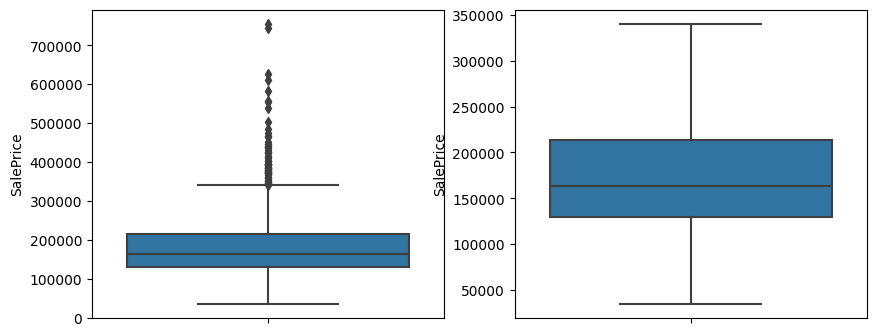

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for cond, subplot in zip((True, False), ax.flatten()):
  sns.boxplot(y=df['SalePrice'], showfliers=cond, ax= subplot)

Podemos apreciar que el dataset cuenta con una buena cantidad de outliers, estos seran manejados una vez que obtengamos los errores en la regresión lineal. 

Procedo a hacer una serie de pasos para identificar los outliers.

In [ ]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
df['SalePrice'].quantile(.975)

384510.7499999999

In [ ]:
df['outlier'] = 0
filtro_out = df['SalePrice'] > df['SalePrice'].quantile(.975)
df.loc[filtro_out,'outlier'] = 1

In [ ]:
df['outlier'].value_counts()

0    1423
1      37
Name: outlier, dtype: int64

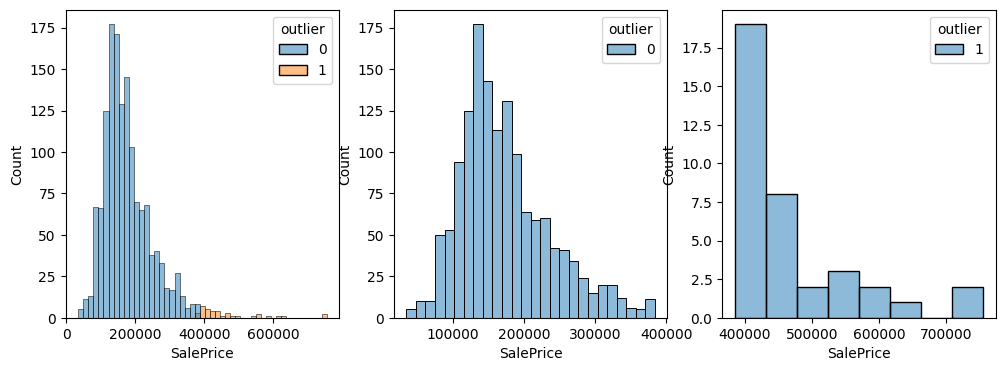

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for dat, subplot in zip((df, df[-filtro_out], df[filtro_out]), ax.flatten()):
  sns.histplot(x='SalePrice', hue='outlier', 
               data=dat, ax=subplot )
plt.show()

Se puede apreciar que los datos no tienen una distribucion normal, si no similar a la distribucion de Laplace, con una cola muy abierta hacia la derecha, donde se destacan los outliers señalados en amarillo. Se puede apreciar que los datos tienen un leve sesgo positivo.

# Comparación Regresión lineal, Regresión robusta, Regresión polinomial

In [ ]:
y = df['SalePrice']
X = df.drop(['SalePrice','outlier'],
            axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    random_state=261)

# Guardamos datos preprocesados

In [ ]:
df_preprocesado = pd.concat([X,y], axis=1)
# Compruebo dimensiones
X.shape,    y.shape,   df_preprocesado.shape

((1460, 191), (1460,), (1460, 192))

In [ ]:
# Guardo en el drive
df_preprocesado.to_csv('/content/drive/MyDrive/Colab Notebooks/ML & AI for the Working Analyst/WA2301.8 - Mar 28 - 31, 2023/df_selec.csv')

NameError: ignored

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (1095, 191)
y:  (1095,)
Conjunto de prueba
X:  (365, 191)
y:  (365,)


Una vez separados los datos para entrenamiento y prubea, procederemos a realizar la regresion lineal.

## Regresión Lineal

In [ ]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

18616.343697021264

In [ ]:
metrics.mean_absolute_error(y_test, y_pred)

18616.343697021264

In [ ]:
# Calculamos los errores
errores = (np.array(y_test) - y_pred)
len(errores)

365

In [ ]:
# Una de las hipotesis de la regresión es que los errores son
# independientes entre sí, teniendo una distribución normal

media = np.mean(y_test - y_pred)           
des_est = np.sqrt(np.var(y_test - y_pred))

media,des_est

(-1193.8133486173263, 25444.66043516799)

### Comparación de los errores empirícos con una la distribución normal

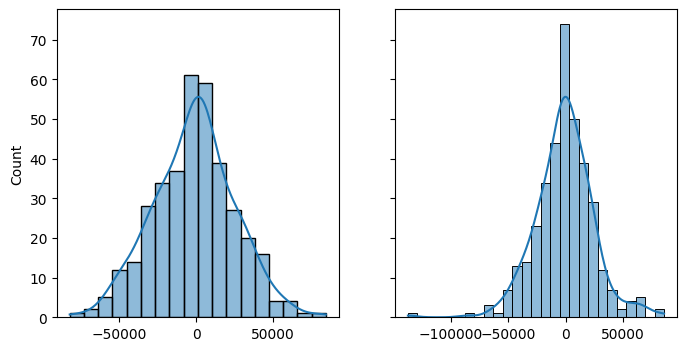

In [ ]:
# Comparación de la distribución teórica(normal) y empirica de los errores

errores_teoricos = np.random.normal(media, des_est, 365)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores), ax.flatten()):
  sns.histplot(x=dat, ax=subplot, kde=True, )
  
plt.show()

Como podemos observar, los errores no cuentan con una distribucion normal como tal, se ve un nivel de curtosis grande, teniendo los errores del lado derecho del grafico.

### Calculo de [$R^2$](https://docs.google.com/presentation/d/1k0aYwEBzaaAkWjX6jRKAc40nKHi3FROkJwtXCOE22mI/edit#slide=id.ga8926b2cd2_0_14)



$MSE = \cfrac{1}{n}\sum{( y - y_{pred})}^2$

 $R^2 	= 1 -  \cfrac{MSE(modelo)}{MSE(linea~base)}$


In [ ]:
# Error cuadrado medio (MSE) linea base (promedio de las etiquetas)

errores_lb = y_test - y_test.mean()
MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
MSE_base

5127573048.617347

In [ ]:
#Error cuadrado medio (MSE) modelo
errores = y_test - y_pred

MSE_modelo = pow(errores,2).sum()/len(errores)
MSE_modelo

648855934.9723402

In [ ]:
R2 = 1 - MSE_modelo/MSE_base #¿cuánto mejora la predicción nuestro modelo?
R2

0.8734574956182624

R2 muestra, en lo general, que tan bien se estan almodando mis datos al modelo, es decir, que tan bien las variables X explican la variable y. Mi interpretación es que el modelo, con los features seleccionados, hace un buen trabajo.

In [ ]:
R2 = 1 - MSE_base/MSE_base
R2

0.0

In [ ]:
def R_cuadrada(val_obs, val_pred):
  errores_lb = val_obs - val_obs.mean()
  errores_m = val_obs - val_pred
  MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
  MSE_modelo = pow(errores,2).sum()/len(errores)
  R2 = 1 - MSE_modelo/MSE_base
  return R2

In [ ]:
R_cuadrada(y_test, y_pred)

0.8734574956182624

In [ ]:
metrics.r2_score(y_test, y_pred)

0.8734574956182624

<ipython-input-4-407433e55bfd>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(predictions,y_test,cmap='plasma',alpha=0.5)


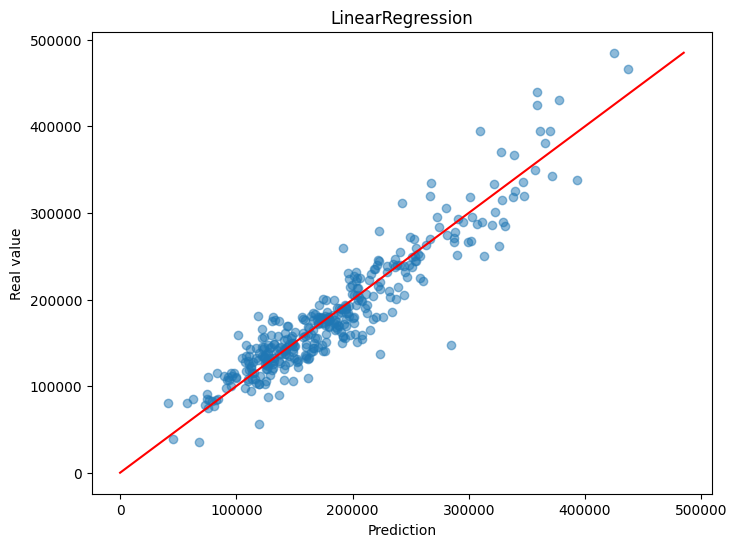

Mean Absolute Error: 18616.343697021264
Mean Squared Error: 648855934.9723402
Root Mean Squared Error: 0.15403770126578728


In [ ]:
estimator = LinearRegression()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
#print(ytest)
regressionEvaluationMetrics(y_pred,y_test,'LinearRegression')

Podemos apreciar como en la gráfica de dispersion para la Regresión Lineal, tenemos resultados satisfactorios. Procederemos a estimar el modelo con la Regresión de Huber.

## Regresión Robusta

La Regresión de Huber o Robusta se diferencia de la regresión lineal, al suavizar el efecto de los outliers encontrados una vez obtenido epsilon. A continuación veremos que resultados arroja sobre este mismo dataset.

In [ ]:
hr = HuberRegressor(epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, y_train)
y_pred = hr.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

22840.364224353954
MAE: 22840.364224353954


In [ ]:
hr.coef_

array([-8.56239091e+01,  7.05486107e-01,  4.18132769e+01,  1.12766003e+01,
       -5.78835622e+02, -4.63057368e+02,  2.77526608e+01,  1.91403928e+01,
        2.82699782e+00,  1.09823878e+00,  2.30656294e+01,  6.68470111e-01,
       -7.56767513e+01,  6.24158100e+01,  2.11199261e+00, -1.36138360e+00,
        5.78865608e+00,  4.84553406e-01, -1.18775270e+01, -2.67430421e+00,
        4.99628862e+00,  1.75598880e+01,  2.10258808e+01,  5.51814179e+01,
        3.57568439e+01,  1.87785019e+01,  5.87415820e+01,  4.34855822e+01,
        9.99498191e-01, -1.80873303e+00,  3.38015711e+01,  2.62919791e+00,
       -5.68568423e-01,  1.30561187e+00,  3.56277205e-01,  9.41400268e-01,
       -4.22036431e-02, -4.55118980e+00,  1.34855495e+00, -3.49045064e-01,
       -4.98491168e-01,  0.00000000e+00,  1.15645434e+00,  2.58954664e-01,
       -5.52392690e-01,  4.88871178e-02, -4.61331142e-01,  0.00000000e+00,
       -8.31820711e-01,  8.00365169e-01, -5.75591981e-01,  1.75590850e+00,
        1.58104839e+00, -

In [ ]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

coef               variable
0   -578.835622              YearBuilt
1   -463.057368           YearRemodAdd
2    -85.623909             MSSubClass
3    -75.676751           LowQualFinSF
4    -12.163649      Foundation_CBlock
5    -11.877527           BedroomAbvGr
6     -9.405483           HeatingQC_TA
7     -8.597582        BsmtExposure_No
8     -6.098357       GarageFinish_Unf
9     -4.551190           LotShape_Reg
10    -4.308548     Neighborhood_NAmes
11    -3.704019       BsmtFinType1_BLQ
12    -3.587001       BsmtFinType1_Rec
13    -3.515645    Exterior1st_HdBoard
14    -3.275348    Exterior1st_Plywood
15    -2.945110     MasVnrType_BrkFace
16    -2.843909     GarageType_Missing
17    -2.674304           KitchenAbvGr
18    -2.450704    Exterior1st_Wd Sdng
19    -2.421217       Condition1_Feedr
20    -2.351323    Neighborhood_NWAmes
21    -2.016224   Neighborhood_OldTown
22    -1.926163        BldgType_Duplex
23    -1.808733                 MoSold
24    -1.774697       BsmtFinType1_LwQ
25    -1.774102   Neighborhood_Edwards
26    -1.692955           HeatingQC_Gd
27    -1.578155   Neighborhood_Mitchel
28    -1.540394        Functional_Min1
29    -1.453948           ExterCond_Gd
30    -1.361384           BsmtHalfBath
31    -1.259741   SaleCondition_Normal
32    -1.209650        BldgType_2fmCon
33    -1.180511        RoofStyle_Gable
34    -1.108149    Neighborhood_Sawyer
35    -1.043591        Functional_Min2
36    -0.935522           ExterCond_Fa
37    -0.889448          GarageQual_Fa
38    -0.851028           ExterQual_Fa
39    -0.847176   SaleCondition_Family
40    -0.831821    Neighborhood_BrDale
41    -0.798908       BsmtFinType2_Rec
42    -0.797060     Neighborhood_SWISU
43    -0.749094           HeatingQC_Fa
44    -0.697658         BldgType_Twnhs
45    -0.697537    Exterior1st_MetalSd
46    -0.695800       BsmtFinType2_LwQ
47    -0.593144          GarageCond_Fa
48    -0.580206         KitchenQual_Fa
49    -0.579464    Neighborhood_IDOTRR
50    -0.575592   Neighborhood_ClearCr
51    -0.568568            MSZoning_RH
52    -0.552393       LotConfig_Inside
53    -0.540488         Functional_Mod
54    -0.534099            BsmtCond_TA
55    -0.505496   Neighborhood_SawyerW
56    -0.498491        LandContour_Lvl
57    -0.461331          LandSlope_Sev
58    -0.434845   Neighborhood_MeadowV
59    -0.360062       BsmtFinType2_BLQ
60    -0.349045        LandContour_Low
61    -0.302919     GarageType_CarPort
62    -0.249654        Functional_Maj2
63    -0.234325        Condition1_PosN
64    -0.230619           PavedDrive_P
65    -0.222374        Condition1_PosA
66    -0.221113       Electrical_FuseF
67    -0.198512   Neighborhood_NPkVill
68    -0.196226      HouseStyle_2.5Fin
69    -0.189563        Condition1_RRAe
70    -0.174299            BsmtCond_Po
71    -0.173451           Heating_OthW
72    -0.173066       RoofMatl_WdShake
73    -0.145891         SaleType_ConLD
74    -0.137832       Electrical_FuseP
75    -0.130468           Heating_Grav
76    -0.099862  SaleCondition_AdjLand
77    -0.092524     MasVnrType_Missing
78    -0.088104           SaleType_Oth
79    -0.087444        Condition1_RRNn
80    -0.087150          RoofMatl_Roll
81    -0.084716          GarageCond_Po
82    -0.079006    Exterior2nd_AsphShn
83    -0.077996         SaleType_ConLI
84    -0.076244    Exterior1st_AsphShn
85    -0.074490     Exterior1st_CBlock
86    -0.062267    Exterior2nd_Brk Cmn
87    -0.057631          GarageQual_Po
88    -0.042677       Condition2_Feedr
89    -0.042204           LotShape_IR3
90    -0.030632    Exterior2nd_ImStucc
91    -0.021926      HouseStyle_2.5Unf
92    -0.006381    Exterior1st_BrkComm
93     0.000000   Neighborhood_Blueste
94     0.000000         RoofStyle_Shed
95     0.000000       Utilities_NoSeWa
96     0.000000           ExterCond_Po
97     0.000000        Condition2_RRAn
98     0.000000    Exterior1st_ImStucc
99     0.000000         Functional_Sev
100    0.000060        Condition2_PosN
101    0.003460            BsmtQu

Los coeficientes con un impacto negativo mas fuerte son YearBuilt (años transcurridos desde la construcción), YearRemodAdd(años transcurridos desde la remodelación), MSSubClass (clase de construccion), y LowQualFinsSF (Pies cuadrados de acabados de baja calidad). Todas estas variables hacen sentido de por que disminuirian el precio predecido de una casa, ya que entre mas antigua y de peor calidad la construccion, menos valor tendra una casa en el mercado.

Sobre los coeficientes con mayor impacto positivo, se encuentra GrLivArea (Area de estar en segundo piso), ScreenPorch (area de porche de pantalla), OpenPorchSF (area de porche en pies cuadrados) y OverallQual (calidad de los materiales y acabados). La que mayor impacto y sentido hace en el mercado de bienes inmuebles es el area de estar, por lo cual podemos deducir que a mayor espacio, mayor precio tendra una casa en el mercado.

<ipython-input-4-407433e55bfd>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(predictions,y_test,cmap='plasma',alpha=0.5)


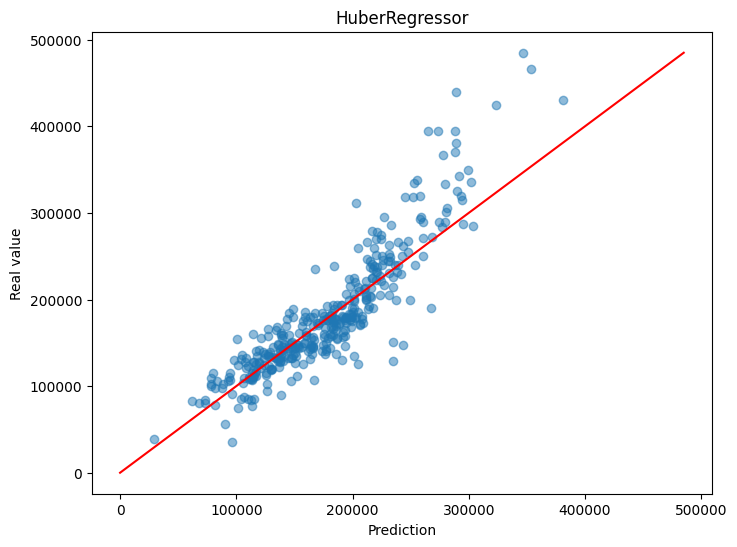

Mean Absolute Error: 22840.364224353954
Mean Squared Error: 1089454937.085305
Root Mean Squared Error: 0.17288162009434643


In [ ]:
estimator = HuberRegressor(epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False, 
                    fit_intercept=True, tol=1e-05)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
#print(ytest)
regressionEvaluationMetrics(y_pred,y_test,'HuberRegressor')

Podemos ver que la regresion de Huber cuenta con un peor rendimeinto, tanto en el MAE como en el MSE, por lo que una regresion lineal tiene un mejor desempeño con este dataset, sin embargo, la regresion robusta no hace un mal trabajo.

## Regresión Polinomial

In [ ]:
def regressionEvaluationMetrics(predictions,y_test,title):
    
    plt.figure(figsize=(8,6))
    plt.scatter(predictions,y_test,cmap='plasma',alpha=0.5)
    plt.xlabel('Prediction')
    plt.ylabel('Real value')
    plt.title(title)
    diagonal = np.linspace(0, np.max(y_test), 100)
    plt.plot(diagonal, diagonal, '-r')
    plt.show()
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))

In [ ]:
df_muestra = df.sample(frac=.2)
df_muestra.shape

(292, 193)

In [ ]:
y = df_muestra['SalePrice']
X = df_muestra.drop(['SalePrice'],axis=1)

In [ ]:
polynomial_features = PolynomialFeatures(degree=2)
X_poly= polynomial_features.fit_transform(X)
X.shape, X_poly.shape

((292, 192), (292, 18721))

### Separación conjunto de entrenamiento y prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    random_state=261)

In [ ]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (219, 18721)
y:  (219,)
Conjunto de prueba
X:  (73, 18721)
y:  (73,)


In [ ]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

54616.02174146264

<ipython-input-70-99ca3e18884b>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(predictions,y_test,cmap='plasma',alpha=0.5)


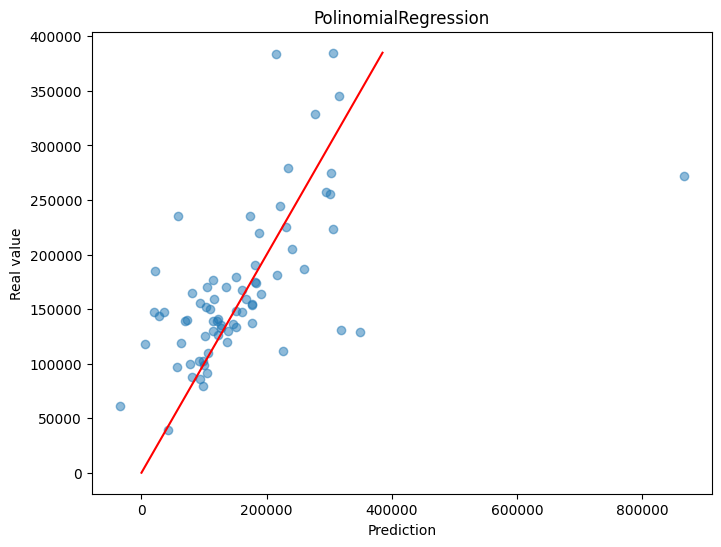

Mean Absolute Error: 54616.02174146264
Mean Squared Error: 9392467151.410862


In [ ]:
estimator = LinearRegression()
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
#print(ytest)
regressionEvaluationMetrics(y_pred,y_test,'PolinomialRegression')

La regresión polinomial es utilizada cuando en el dataset, la relacion entre las variables explicativas y la variable objetivo no es lineal.

Para el caso presente, la regresión polinomial obtuvo el peor desempeño de los tres algoritmos utilizados. Esto se debe a que si hay un cierto grado de relacion lineal entre las variables utilizadas en este dataset.

# Conclusiones

Antes de entrar directamente sobre los resultados obtenidos, resalto que es posible reducir la dimensionalidad del dataset aun mas, utilizando tecnicas mas avanzadas, como lo seria PCA (Principal Component Analysis).

Las regresiones Lineales y de Huber presentaron resultados satisfactorios sobre la base de datos utilizada. La base de datos presenta outliers, sin embargo, a penas fueron en 37 registros de 1,460, es decir, aproximadamente 2.5% de los registros encontrados en la base de datos, por lo que no es de sorprender que la Regresion Lineal tuviera tan buenos resultados como Huber.



# Referencias

* García, S., Luengo, J., & Herrera, F. (2015). Data Preprocessing in Data Mining. Intelligent Systems Reference Library. doi:10.1007/978-3-319-10247-4


* Hawkins, D. M. (1980). Identification of Outliers. Springer Netherlands. https://doi.org/10.1007/978-94-015-3994-4


* McDonald, A. (2021, septiembre 8). Using the missingno Python library to Identify and Visualise Missing Data Prior to Machine Learning. Medium. https://towardsdatascience.com/using-the-missingno-python-library-to-identify-and-visualise-missing-data-prior-to-machine-learning-34c8c5b5f009

* Chandrashekar, G., & Sahin, F. (2014). A survey on feature selection methods. Computers & Electrical Engineering, 40(1), 16-28. https://doi.org/10.1016/j.compeleceng.2013.11.024


.


